<a href="https://colab.research.google.com/github/LolitaOnayeva/Detecting-Mental-Health-Conditions-on-Reddit-using-NLP-and-machine-learning-/blob/main/Bigram_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import csv                               
import re                                       
from sklearn.svm import LinearSVC
from nltk.classify import SklearnClassifier
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support 
from random import shuffle
import numpy as np
from collections import Counter
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
def parseReview(reviewLine): 
    Post=reviewLine[3] 
    Mental_Health_Condition=reviewLine[6]
    

    return (Post,Mental_Health_Condition)

In [ ]:
def preProcess(text):
    text = re.sub(r"(\w)([.,;:!?'\"”\)])", r"\1 \2", text) 
    text = re.sub(r"([.,;:!?'\"“\(])(\w)", r"\1 \2", text)
    text = re.sub(r"(\S)\1\1+",r"\1\1\1", text)
    text = re.sub(r'[^A-Za-z0-9 ]+','', text)  # remove non- english characters such as Äö 
     
    tokens = text.split(" ")
    tokens = [t.lower() for t in tokens]
    pairs = [ " ".join(pair) for pair in nltk.ngrams(tokens,2)]
    
    return pairs


In [ ]:
featureDict = {} 

def toFeatureVector(lemmatized_tokens):
    v = {}
    for t in lemmatized_tokens:
        try:
            featureDict[t] += 1
        except KeyError:            
            featureDict[t] = 1
        try:
            v[t] += (1.0/len(lemmatized_tokens))
        except KeyError:
            v[t] = (1.0/len(lemmatized_tokens))
    return v

In [ ]:
# Downloading datasets 
rawTrainData=[]
with open("/content/drive/MyDrive/mental_health_data/full_mental_health_df_train.csv") as f:
    reader = csv.reader(f,quoting=csv.QUOTE_ALL, skipinitialspace=True)
    for line in reader:   
        (Post,Mental_Health_Condition) = parseReview(line)
        rawTrainData.append((Post,Mental_Health_Condition))
        
rawTestData=[]
with open('/content/drive/MyDrive/mental_health_data/full_mental_health_df_test.csv') as f:
    reader = csv.reader(f,quoting=csv.QUOTE_ALL, skipinitialspace=True)
    for line in reader:   
        (Post,Mental_Health_Condition) = parseReview(line)
        rawTestData.append((Post,Mental_Health_Condition))

testData=[]
trainData=[]

for (Mental_Health_Condition,Post) in rawTrainData:
        #trainData.append((Mental_Health_Condition,toFeatureVector(preProcess(Post))))
        trainData.append((toFeatureVector(preProcess(Post)),Mental_Health_Condition))

for (Mental_Health_Condition,Post) in rawTestData:
        #testData.append((Mental_Health_Condition,toFeatureVector(preProcess(Post))))
        testData.append((toFeatureVector(preProcess(Post)),Mental_Health_Condition))

In [ ]:
testData[600]

({' and': 0.007067137809187279,
  ' but': 0.0035335689045936395,
  ' has': 0.0035335689045936395,
  ' he': 0.0035335689045936395,
  ' how': 0.007067137809187279,
  ' i': 0.0176678445229682,
  ' in': 0.0035335689045936395,
  ' m': 0.0035335689045936395,
  ' or': 0.0035335689045936395,
  ' s': 0.014134275618374558,
  ' subsequently': 0.0035335689045936395,
  ' t': 0.0035335689045936395,
  ' though': 0.0035335689045936395,
  ' ve': 0.010600706713780918,
  '99 of': 0.0035335689045936395,
  'a bit': 0.0035335689045936395,
  'a burden': 0.0035335689045936395,
  'a head': 0.0035335689045936395,
  'a lot': 0.0035335689045936395,
  'a panic': 0.0035335689045936395,
  'a teen': 0.0035335689045936395,
  'a wakeup': 0.0035335689045936395,
  'abandonment and': 0.0035335689045936395,
  'ability to': 0.0035335689045936395,
  'about how': 0.0035335689045936395,
  'absolutely terrified': 0.0035335689045936395,
  'abused me': 0.0035335689045936395,
  'addition to': 0.0035335689045936395,
  'after he': 0

In [ ]:
# Lenght of the datasets
print("Now  %d trainData, %d testData" % ( len(trainData), len(testData)))

# Number of features
print("Training Samples: ", len(trainData), "Features: ", len(featureDict), sep='\n')

Now  122073 trainData, 30893 testData
Training Samples: 
122073
Features: 
2284610


In [ ]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

In [ ]:
# Training and validating classifier
def trainClassifier(trainData):
    print("Training Classifier...")
    pipeline = Pipeline([('tfidf', TfidfTransformer()),('svc', LinearSVC(penalty='l2', loss='hinge', dual=True, tol=0.0001, C=1, multi_class='ovr', fit_intercept=True, intercept_scaling=1, class_weight=None, verbose=0, random_state=None))])
    return SklearnClassifier(pipeline).train(trainData)


In [ ]:
# Predicting labels given a classifier
def predictLabels(reviewSamples, classifier):
    return classifier.classify_many(map(lambda t: t[0], reviewSamples))

In [ ]:
# Cross-Validate
def crossValidate(dataset, folds):
    shuffle(dataset)
    results = []
    foldSize = int(len(dataset)/folds)
    
    for i in range(0,len(dataset),int(foldSize)):
        # insert code here that trains and tests on the 10 folds of data in the dataset
        print("Fold start on items %d - %d" % (i, i+foldSize))
        myTestData = dataset[i:i+foldSize]
        myTrainData = dataset[:i] + dataset[i+foldSize:]
        classifier = trainClassifier(myTrainData)
        y_true = [x[1] for x in myTestData]
        y_pred = predictLabels(myTestData, classifier)
        results.append(precision_recall_fscore_support(y_true, y_pred, average='weighted'))
        
    print(zip(*results))
    avgResults = [np.mean([x[0] for x in results]),
                  np.mean([x[1] for x in results]),
                  np.mean([x[2] for x in results])
                ]
    return avgResults

In [ ]:
#cv_results = crossValidate(trainData, 10)
#print(cv_results)

In [ ]:
functions_complete = True  
if functions_complete:
    print(testData[0])   
    classifier = trainClassifier(trainData)  
    testTrue = [t[1] for t in testData]   
    testPred = predictLabels(testData, classifier)  
    finalScores = precision_recall_fscore_support(testTrue, testPred, average='weighted') 
    print("Done training!")
    print("Precision: %f\nRecall: %f\nF Score:%f" % finalScores[:3])

({'rant about': 0.0024096385542168677, 'about anxiety': 0.0024096385542168677, 'anxiety meds': 0.0024096385542168677, 'meds ': 0.0024096385542168677, ' i': 0.012048192771084338, 'i ': 0.012048192771084338, ' ve': 0.0072289156626506035, 've been': 0.004819277108433735, 'been self': 0.0024096385542168677, 'self medicating': 0.0024096385542168677, 'medicating with': 0.0024096385542168677, 'with benzodiazepines': 0.0024096385542168677, 'benzodiazepines ': 0.0024096385542168677, ' valium': 0.0024096385542168677, 'valium ': 0.004819277108433735, ' first': 0.0024096385542168677, 'first it': 0.0024096385542168677, 'it started': 0.0024096385542168677, 'started with': 0.0024096385542168677, 'with cannabis': 0.0024096385542168677, 'cannabis ': 0.0024096385542168677, ' a': 0.0024096385542168677, 'a very': 0.0024096385542168677, 'very no': 0.0024096385542168677, 'no nonsense': 0.0024096385542168677, 'nonsense substance': 0.0024096385542168677, 'substance at': 0.0024096385542168677, 'at face': 0.002

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Done training!
Precision: 0.781356
Recall: 0.779626
F Score:0.774598


In [ ]:
print(metrics.classification_report(testTrue, testPred))

                 precision    recall  f1-score   support

        anxiety       0.82      0.76      0.79      4342
  bipolarreddit       0.82      0.30      0.44       340
     conspiracy       0.84      0.92      0.88      1498
     depression       0.72      0.83      0.77     11715
        fitness       0.94      0.96      0.95      3478
     meditation       0.94      0.84      0.89       946
      parenting       0.90      0.92      0.91      1979
personalfinance       0.94      0.79      0.86       337
           ptsd       0.88      0.48      0.62       451
  schizophrenia       0.88      0.47      0.61       505
   suicidewatch       0.65      0.54      0.59      5052
       teaching       0.90      0.72      0.80       250

       accuracy                           0.78     30893
      macro avg       0.85      0.71      0.76     30893
   weighted avg       0.78      0.78      0.77     30893



In [ ]:
labels=['conspiracy','depression','anxiety','bipolarreddit','fitness','meditation','parenting',
        'personalfinance','schizophrenia','suicide','teaching','ptsd']
confusion = confusion_matrix(testTrue, testPred,labels)

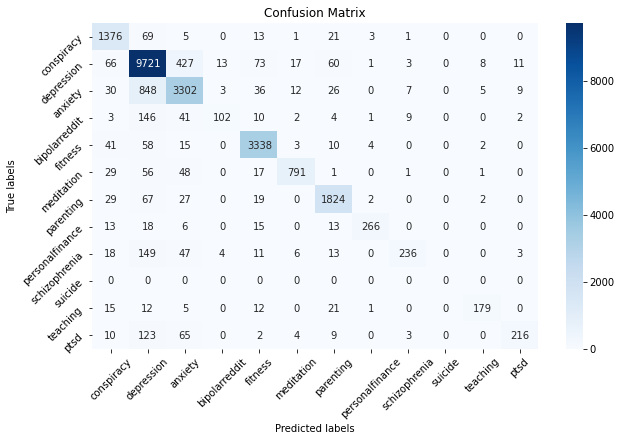

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt     
fig = plt.figure(figsize=(10,6))
ax= plt.subplot()
sns.heatmap(confusion, annot=True, cmap='Blues',fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.set_xticklabels( labels,rotation=45); ax.set_yticklabels(labels,rotation=45);